Converting from returns to log returns gives you mathematical benefits---that is really the key point

log(M*N) = log(M)+log(N)


log(M/N) = log(M) - log(N)

recall we normalize returns to show them as a pct change

normalized_return = (p_end - p_beg)/p_beg   where p_beg= p_end - 1 (i.e. one day back)

In [3]:
import numpy as np
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
start = dt.datetime(2017, 1, 1)
end = dt.datetime(2022, 3, 10)
#Costco, Walmart, Target, Dollar General
COST = pdr.get_data_yahoo("COST", start, end)['Adj Close']
WMT = pdr.get_data_yahoo("WMT", start, end)['Adj Close']
TGT = pdr.get_data_yahoo("TGT", start, end)['Adj Close']
DG = pdr.get_data_yahoo("DG", start, end)['Adj Close']


In [5]:
frames = [COST, WMT, TGT, DG]

retail = pd.concat(frames, axis=1)

retail.columns = ['COST', 'WMT', 'TGT', 'DG']

In [6]:
retail

,COST,WMT,TGT,DG
Date,,,,
2017-01-03,142.376984,62.041485,63.012440,70.633270
2017-01-04,142.403763,62.402920,63.930538,72.394569
2017-01-05,145.211502,62.538483,62.847866,70.947426
2017-01-06,145.140244,61.680054,61.877785,69.833519
2017-01-09,143.482285,62.086666,61.869118,70.195328
...,...,...,...,...
2022-03-04,525.500000,142.820007,224.100006,210.979996
2022-03-07,528.520020,141.669998,211.039993,203.720001
2022-03-08,523.359985,138.740005,208.809998,199.259995


In [34]:
#retail log Returns---%holding remaining from previous day (how much do you have left)
log_rets = np.log(retail / retail.shift(1))

In [35]:
log_rets

,COST,WMT,TGT,DG
Date,,,,
2017-01-03,NaN,NaN,NaN,NaN
2017-01-04,0.000188,0.005809,0.014465,0.024630
2017-01-05,0.019525,0.002170,-0.017080,-0.020192
2017-01-06,-0.000491,-0.013821,-0.015556,-0.015825
2017-01-09,-0.011489,0.006571,-0.000140,0.005168
...,...,...,...,...
2022-03-04,-0.014265,0.025027,0.001161,0.022480
2022-03-07,0.005730,-0.008085,-0.060045,-0.035017
2022-03-08,-0.009811,-0.020899,-0.010623,-0.022136


In [36]:
#need random weights to test portfolio (must add up to one)
N = len(retail.columns)

In [48]:
#this will give you 4 random numbers between 0 and 1 for N holdings (here this is 4 numbers)
weights = np.random.random(N)

In [49]:
weights

array([0.72799418, 0.51805462, 0.22625066, 0.50496222])

In [50]:
#need to make sure they sum to 1 so you are basically reversing an average
weights = weights / np.sum(weights)

In [51]:
weights

array([0.36818302, 0.2620061 , 0.11442626, 0.25538462])

In [52]:
weights.sum()

1.0

In [53]:
#lets turn the above into a reusable function
def gen_weights(N):
    weights = np.random.random(N)
    #need to make sure they sum to 1
    return weights / np.sum(weights)

In [54]:
gen_weights(4)

array([0.24324804, 0.27789512, 0.28461414, 0.19424269])

In [55]:
#also need to calculate returns
def calculate_returns(weights, log_rets):
    # daily log returns multipled by the weight of each stock----then multiply 252 to annualize it
    return np.sum(log_rets.mean()*weights) * 252

In [56]:
#portfolio variance-----covariance matrix
retail_log_returns.cov()

,COST,WMT,TGT,DG
COST,0.000186,0.000108,0.000124,0.000107
WMT,0.000108,0.000186,0.000119,0.000110
TGT,0.000124,0.000119,0.000379,0.000174
DG,0.000107,0.000110,0.000174,0.000248


In [60]:
def calculate_volatility(weights, log_rets_cov):
    annualized_covariance = np.dot(log_rets_cov*252, weights)
    #volatility
    vol = np.dot(weights.transpose(), annualized_covariance)
    #get std dev
    return np.sqrt(vol)

In [61]:
calculate_volatility(weights, retail_log_returns.cov())

0.1895362622345122

In [64]:
#re-define these to make sure they are set
log_rets = np.log(retail/retail.shift(1))
log_rets_cov = log_rets.cov()

In [86]:
#monte carlo portfolio returns, volatility,weights
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []

for sim in range(50000):
    weights = gen_weights(N=4)
    mc_weights.append(weights)
    
    sim_returns = (calculate_returns(weights, log_rets))
    mc_portfolio_returns.append(sim_returns)
    
    
    sim_vol = calculate_volatility(weights, log_rets_cov)
    mc_portfolio_vol.append(sim_vol)

In [87]:
len(mc_portfolio_returns)

50000

In [88]:
#assuming risk free rate is 0 for sharpe ratio
mc_sharpe_ratios = np.array(mc_portfolio_returns)/np.array(mc_portfolio_vol)

Text(0, 0.5, 'Return')

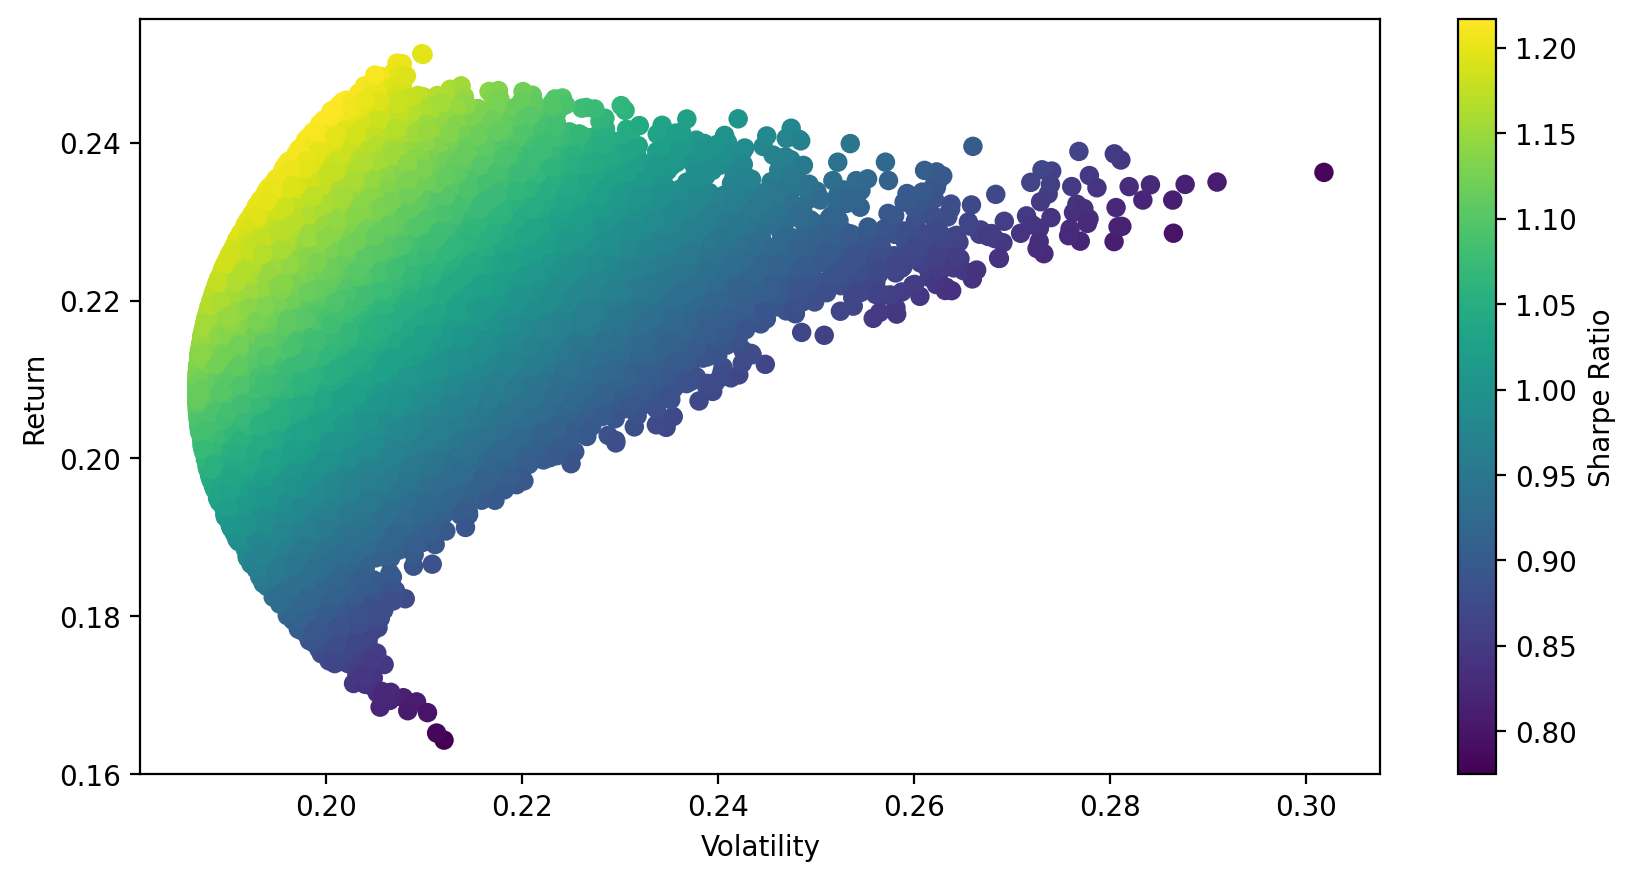

In [89]:
plt.figure(dpi=200, figsize=(10,5))
plt.scatter(mc_portfolio_vol, mc_portfolio_returns, c=mc_sharpe_ratios)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')


In [90]:
#Will give you back the highest sharpe ratio
highest_sharpe = np.argmax(mc_sharpe_ratios)

In [91]:
mc_weights[highest_sharpe]

array([0.73302861, 0.01047621, 0.08357737, 0.1729178 ])

In [92]:
retail

,COST,WMT,TGT,DG
Date,,,,
2017-01-03,142.376984,62.041485,63.012440,70.633270
2017-01-04,142.403763,62.402920,63.930538,72.394569
2017-01-05,145.211502,62.538483,62.847866,70.947426
2017-01-06,145.140244,61.680054,61.877785,69.833519
2017-01-09,143.482285,62.086666,61.869118,70.195328
...,...,...,...,...
2022-03-04,525.500000,142.820007,224.100006,210.979996
2022-03-07,528.520020,141.669998,211.039993,203.720001
2022-03-08,523.359985,138.740005,208.809998,199.259995
